# PyTorch Implementation of SNGP

The core concepts of **Spectral-nroamalised Neural Gaussian Process** (SNGP) can be found in the original paper https://arxiv.org/abs/2006.10108. SNGP's main idea is to improve the ability of deep neural networks to retain distance information and to leverage this to determine the distance between test examples and the training data to improve predictive uncertainty estimates. 

This notebook roughly follows the outline of https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb but aims to implement all functionality shown here in PyTorch.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from collections import namedtuple
NetResult = namedtuple('NetResult', ('mean', 'variance'))


Define visualization macros

In [3]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## The two moon dataset

Create the trainining and evaluation datasets from the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [4]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

Evaluate the model's predictive behavior over the entire 2D input space.

In [5]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never sees these OOD examples during training.

In [6]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

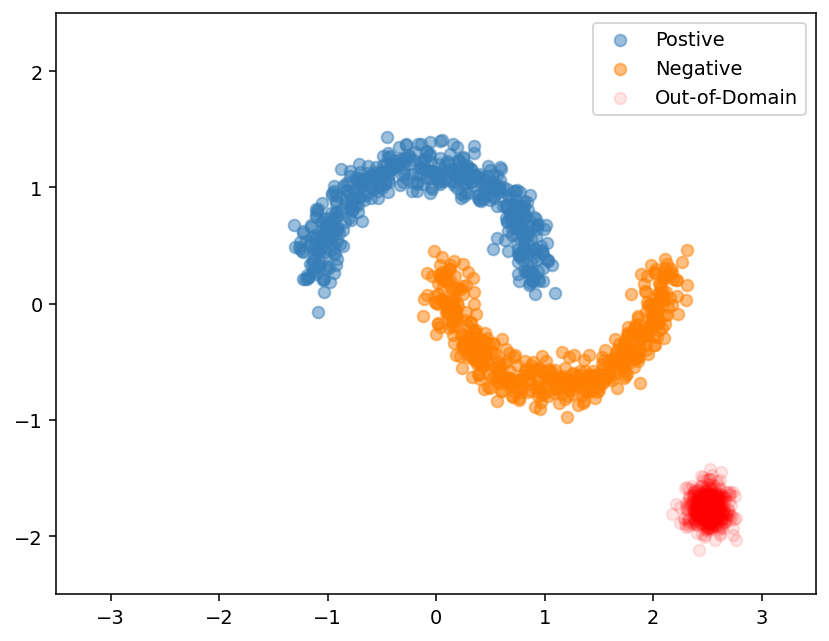

In [7]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

In [8]:
from torch.utils.data import Dataset, DataLoader
class TrainDataset(Dataset):
  def __init__(self):
    self.train_examples = torch.from_numpy(train_examples).type(torch.FloatTensor)
    self.train_labels = torch.from_numpy(train_labels).type(torch.LongTensor)

  def __len__(self):
    return len(self.train_examples)
  
  def __getitem__(self, idx):
    return self.train_examples[idx], self.train_labels[idx]

In [9]:
TrainDataset()

Here the blue and orange represent the positive and negative classes, and the red represents the OOD data. A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

## The deterministic model

### Define model

Start from the (baseline) deterministic model: a multi-layer residual network (ResNet) with dropout regularization.

In [10]:
import torch.nn as nn

class DeepResNet(nn.Module):
  def __init__(self, num_classes, input_features=2, num_hidden_layers=1, num_hidden=128, dropout_rate=0.1):
    super().__init__()
    self.num_hidden = num_hidden
    self.dropout_rate = dropout_rate
    self.input_layer = nn.Linear(in_features=input_features, out_features=num_hidden)
    self.hidden_layers = nn.Sequential(*[nn.Linear(in_features=num_hidden, out_features=num_hidden) for _ in range(num_hidden_layers)])
    self.classifier = nn.Linear(in_features=num_hidden, out_features=num_classes)

  def forward(self, input):
    input = self.input_layer(input)
    for hidden_layer in self.hidden_layers:
      residual = input
      input = F.dropout(F.relu(hidden_layer(input)), p=self.dropout_rate, training=self.training)
      input += residual
    input = self.classifier(input)
    return NetResult(mean=input, variance=None)

### Model training

Configure the training parameters to use `CrossEntropyLoss` as the loss function and the Adam optimizer.

In [29]:
import torch.optim as optim
resnet_config = dict(num_classes=2, num_hidden_layers=6, num_hidden=128, dropout_rate=0.1)
resnet_model = DeepResNet(**resnet_config)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)
resnet_model


DeepResNet(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

In [30]:
training_set = TrainDataset()
training_config = dict(batch_size=128, shuffle=True)
training_loader = DataLoader(training_set, **training_config)
training_set, training_loader

(<__main__.TrainDataset at 0x7f9fb6904510>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9fb6d30690>)

In [31]:
def train_epoch(epoch_index, model, loss_fn, optimizer, call_kwargs):
  running_loss = 0.

  for i, (inputs, labels) in enumerate(training_loader):
    outputs = model(inputs, **call_kwargs).mean
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    # print(running_loss)
    # print(i, inputs.shape, labels.shape)
    
  return running_loss / (i+1) 



In [32]:
def training_loop(model, loss_fn, optimizer, epochs=100, call_kwargs={}):
  torch.autograd.set_detect_anomaly(True)
  model.train(True)

  for epoch in range(epochs):
      model.train(True)
      loss = train_epoch(epoch, model, loss_fn, optimizer, call_kwargs)
      if epoch % 10 == 0:
        print(f'Epoch: {epoch}/{epochs}, Loss: {loss}')
      # can do validation loss below
  model.train(False)


In [33]:
training_loop(model=resnet_model, optimizer=optimizer, loss_fn=loss_fn)

Epoch: 0/100, Loss: 0.7468788325786591
Epoch: 10/100, Loss: 0.06663414277136326
Epoch: 20/100, Loss: 0.029078898252919316
Epoch: 30/100, Loss: 0.012562580115627497
Epoch: 40/100, Loss: 0.005820225109346211
Epoch: 50/100, Loss: 0.002756831658189185
Epoch: 60/100, Loss: 0.0013177456203266047
Epoch: 70/100, Loss: 0.00101257702044677
Epoch: 80/100, Loss: 0.0006746134131390136
Epoch: 90/100, Loss: 0.000553526624571532


### Visualize uncertainty

The following code for plotting the classification and uncertainty surface can be found at https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb#scrollTo=HZDMX7gZrZ-5.

In [34]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

Now visualize the predictions of the deterministic model. First plot the class probability: 
$$p(x) = softmax(logit(x))$$

In [35]:
resnet_logits = resnet_model(torch.Tensor(test_examples)).mean.detach()
resnet_probs = F.softmax(resnet_logits, dim=1).numpy()[:, 0]
resnet_probs

array([1.        , 1.        , 0.9999999 , ..., 0.5718681 , 0.37288663,
       0.20852616], dtype=float32)

In [121]:
def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

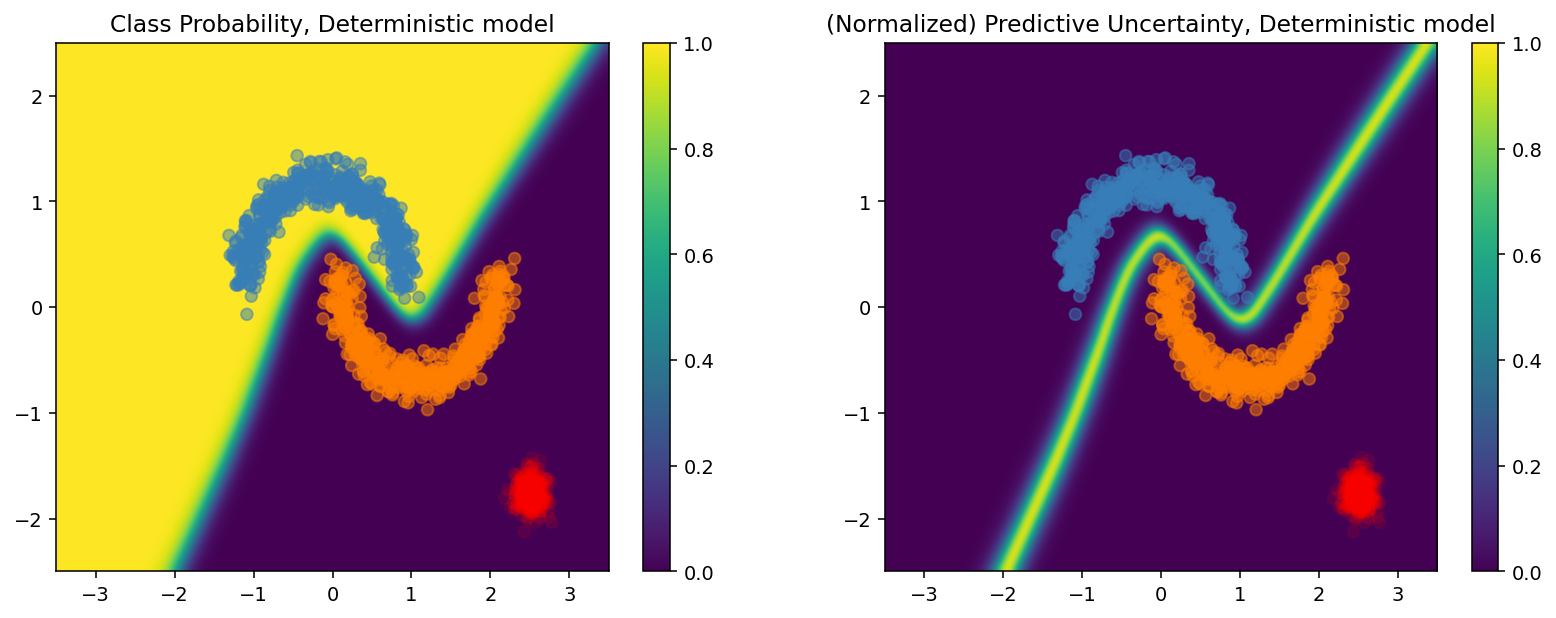

In [122]:
plot_predictions(resnet_probs, 'Deterministic model')

In this plot, the yellow indicates high uncertainty, and the purple indicates low uncertainty. A deterministic ResNet's uncertainty depends only on the test examples' distance from the decision boundary. This leads the model to be over-confident when out of the training domain. The next section shows how SNGP behaves differently on this dataset.

## The SNGP model

The SNGP model should preserve distance from the training data and we can leverage this for better predictive uncertainty estimation.

SNGP requires SpectralNormalisation at the input layer which we will achieve using PyTorch's `torch.nn.utils.parametrizations.spectral_norm`. We can apply this to a linear layer fairly straightforwardly. Taken from https://pytorch.org/docs/stable/generated/torch.nn.utils.parametrizations.spectral_norm.html#torch.nn.utils.parametrizations.spectral_norm:

#### Spectral Normalization

#### The Gaussian Process (GP)

In [76]:
import torch.nn as nn
import torch
import math

# Approximates the gaussian prior (placed after the final hidden layer)
# Nothing needs to be tuned in this module
class RandomFourierFeature(nn.Module):
  def __init__(self, in_features, out_features, output_scale=None):
    super().__init__()
    self.weight = torch.empty(in_features, out_features, requires_grad=False)
    self.bias = torch.empty(out_features, requires_grad=False)
    # Initialised based on https://arxiv.org/pdf/2006.10108.pdf, D_L = out_features
    nn.init.normal_(self.weight)
    nn.init.uniform_(self.bias, a=0, b=2*torch.pi)
    self.output_scale = output_scale or math.sqrt(2/out_features)
  
  def forward(self, input):
    output = input @ self.weight + self.bias
    return self.output_scale * torch.cos(output)

# Approximates the posterior distribution over the gaussian process
class LaplancePosterior(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.beta = nn.Linear(in_features=in_features, out_features=out_features, bias=False)
    nn.init.normal_(self.beta.weight)

  def forward(self, input):
    output = self.beta(input)
    return output 

In [123]:
class SNGP(nn.Module):
  def __init__(self, 
               num_classes, 
               input_features=2, 
               num_hidden_layers=1, 
               num_hidden=128, 
               dropout_rate=0.1, 
               momentum=None, 
               ridge_penalty=1e-6,
               num_inducing=1024,
               norm_multiplier=0.9):
    
    super().__init__()
    self.num_hidden = num_hidden
    self.dropout_rate = dropout_rate
    self.input_layer = nn.Linear(in_features=input_features, out_features=num_hidden)
    self.hidden_layers = nn.Sequential(*[nn.Linear(in_features=num_hidden, out_features=num_hidden) for _ in range(num_hidden_layers)])
    self.random_fourier_feature = RandomFourierFeature(in_features=num_hidden, out_features=num_inducing)
    self.laplace_posterior_linear = LaplancePosterior(in_features=num_inducing, out_features=num_classes)
    self.momentum = momentum 
    self.precision_matrix = ridge_penalty * torch.eye(num_inducing, requires_grad=False)
    self.ridge_penalty = ridge_penalty
    self.norm_multiplier = norm_multiplier

    self.input_layer.register_full_backward_hook(self.spectral_norm_hook)
    for hidden_layer in self.hidden_layers:
      hidden_layer.register_full_backward_hook(self.spectral_norm_hook)

  def forward(self, input, update_precision_matrix=True, mean_field_logits=False):
    input = self.input_layer(input)

    # Standard residual neural network with dropout
    for hidden_layer in self.hidden_layers:
      residual = input
      input = F.dropout(F.relu(hidden_layer(input)), p=self.dropout_rate, training=self.training)
      input += residual

    # Approximation of gaussian process prior on final hidden layer. 
    # Implementation details are based on https://arxiv.org/pdf/2006.10108.pdf 
    random_fourier_feature = self.random_fourier_feature(input)
    output = self.laplace_posterior_linear(random_fourier_feature)

    if update_precision_matrix:     
      self.update_feature_precision_matrix(random_fourier_feature=random_fourier_feature, output_logits=output)
      assert self.precision_matrix.shape[0] == self.precision_matrix.shape[1]

    if not self.training:
      # Compute predictive covariance in inference mode in addition to logits
      variance = self.compute_predictive_variance(random_fourier_feature)
      if mean_field_logits:
        output = self.mean_field_logits(output, variance)
      return NetResult(mean=output, variance=variance)

    return NetResult(mean=output, variance=None)
  
  def spectral_norm_hook(self, module, grad_input, grad_output):
    # applied to linear layer weights
    with torch.no_grad():
      norm = torch.linalg.matrix_norm(module.weight, 2)
      if self.norm_multiplier < norm:
        module.weight = nn.Parameter(self.norm_multiplier * module.weight / norm)

  def mean_field_logits(self, logits, pred_cov):
    # Mean-Field approximation as alternative to MC integration of Gaussian-Softmax
    # Based on: https://arxiv.org/abs/2006.07584
    mean_field_factor = torch.pi / 8.
    logits_scale = torch.sqrt(1.0 + torch.diag(pred_cov) * mean_field_factor)
    logits /= logits_scale.unsqueeze(-1)

    return logits    

  def compute_predictive_variance(self, random_fourier_feature):
    # TODO: cache this for repeated inference so long as feature matrix is unchanged
    cov = torch.inverse(self.precision_matrix)
    pred_cov = random_fourier_feature @ ((cov @ random_fourier_feature.t()) * self.ridge_penalty)
    return pred_cov


  def update_feature_precision_matrix(self, random_fourier_feature, output_logits):
    print('update_feature_precision_matrix')
    batch_size = int(random_fourier_feature.shape[0])
    # D_L x D_L <= p * (1 - p)
    # batch_size x D_L <= kernel_cov_matrix
    prob = torch.sigmoid(output_logits)
    prob_multiplier = prob * (1. - prob)
    adjusted_feature = torch.matmul(torch.sqrt(prob_multiplier).t(), random_fourier_feature)
    precision_matrix_minibatch = torch.matmul(adjusted_feature.t(), adjusted_feature)

    if self.momentum and self.momentum > 0:
      precision_matrix_minibatch = precision_matrix_minibatch / batch_size
      self.precision_matrix = (self.momentum * self.precision_matrix) + ((1. - self.momentum) * precision_matrix_minibatch)
    else:
      # Only call once passing in entire population
      self.precision_matrix = self.precision_matrix + precision_matrix_minibatch



In [133]:
import torch.optim as optim
sngp_config = dict(num_classes=2, num_hidden_layers=6, num_hidden=128, dropout_rate=0.1, momentum=None, norm_multiplier=0.9)
sngp_model = SNGP(**sngp_config)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(sngp_model.parameters(), lr=1e-3)
sngp_model

SNGP(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=128, bias=True)
  )
  (random_fourier_feature): RandomFourierFeature()
  (laplace_posterior_linear): LaplancePosterior(
    (beta): Linear(in_features=1024, out_features=2, bias=False)
  )
)

In [134]:
train_call_kwargs = dict(update_precision_matrix=sngp_model.momentum is not None)

In [135]:
training_loop(sngp_model, loss_fn, epochs=500, optimizer=optimizer, call_kwargs=train_call_kwargs)

Epoch: 0/500, Loss: 0.9230659604072571
Epoch: 10/500, Loss: 0.5288888402283192
Epoch: 20/500, Loss: 0.3737623021006584
Epoch: 30/500, Loss: 0.3070513028651476
Epoch: 40/500, Loss: 0.23289338499307632
Epoch: 50/500, Loss: 0.1945341695100069
Epoch: 60/500, Loss: 0.16060339473187923
Epoch: 70/500, Loss: 0.14329222030937672
Epoch: 80/500, Loss: 0.1213542278856039
Epoch: 90/500, Loss: 0.10588283464312553
Epoch: 100/500, Loss: 0.10292512271553278
Epoch: 110/500, Loss: 0.08568188594654202
Epoch: 120/500, Loss: 0.0735163651406765
Epoch: 130/500, Loss: 0.07476855628192425
Epoch: 140/500, Loss: 0.06172488653101027
Epoch: 150/500, Loss: 0.04434299375861883
Epoch: 160/500, Loss: 0.04350607097148895
Epoch: 170/500, Loss: 0.0416767371352762
Epoch: 180/500, Loss: 0.03855273546651006
Epoch: 190/500, Loss: 0.030174392042681575
Epoch: 200/500, Loss: 0.04018330201506615
Epoch: 210/500, Loss: 0.0323102124966681
Epoch: 220/500, Loss: 0.028532872325740755
Epoch: 230/500, Loss: 0.021959291771054268
Epoch: 24

In [136]:
sngp_model.eval()
sngp_logits, sngp_covmat = sngp_model(torch.Tensor(test_examples), update_precision_matrix=True, mean_field_logits=True)
sngp_variance = torch.diag(sngp_covmat.detach())[:, None]

update_feature_precision_matrix


In [137]:
sngp_variance.shape, sngp_logits.shape

(torch.Size([10000, 1]), torch.Size([10000, 2]))

Computing the posterior predictive probability. We could use Monte Carlo sampling but this requires multiple inferences and removes the latency benefits of SNGP over using ensembles or MC dropout to estimate predictive uncertainty. Instead, we approximate $E(p(x))$ using the mean-field method:

$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt(1 + \lambda \sigma^2(x))})$

where often $\lambda$ is chosen as $\pi/8$ or $3/\pi^2$.

In [138]:
sngp_probs = F.softmax(sngp_logits, dim=1).detach().numpy()[:, 0]
sngp_probs.shape

(10000,)

In [139]:
sngp_probs[:20]

array([0.5908422 , 0.5642411 , 0.53606033, 0.50672597, 0.4769363 ,
       0.4485287 , 0.42216018, 0.39776438, 0.37508875, 0.35148546,
       0.32843456, 0.30810648, 0.29192048, 0.27979627, 0.27161822,
       0.2657232 , 0.26326114, 0.26258528, 0.2642833 , 0.27074632],
      dtype=float32)

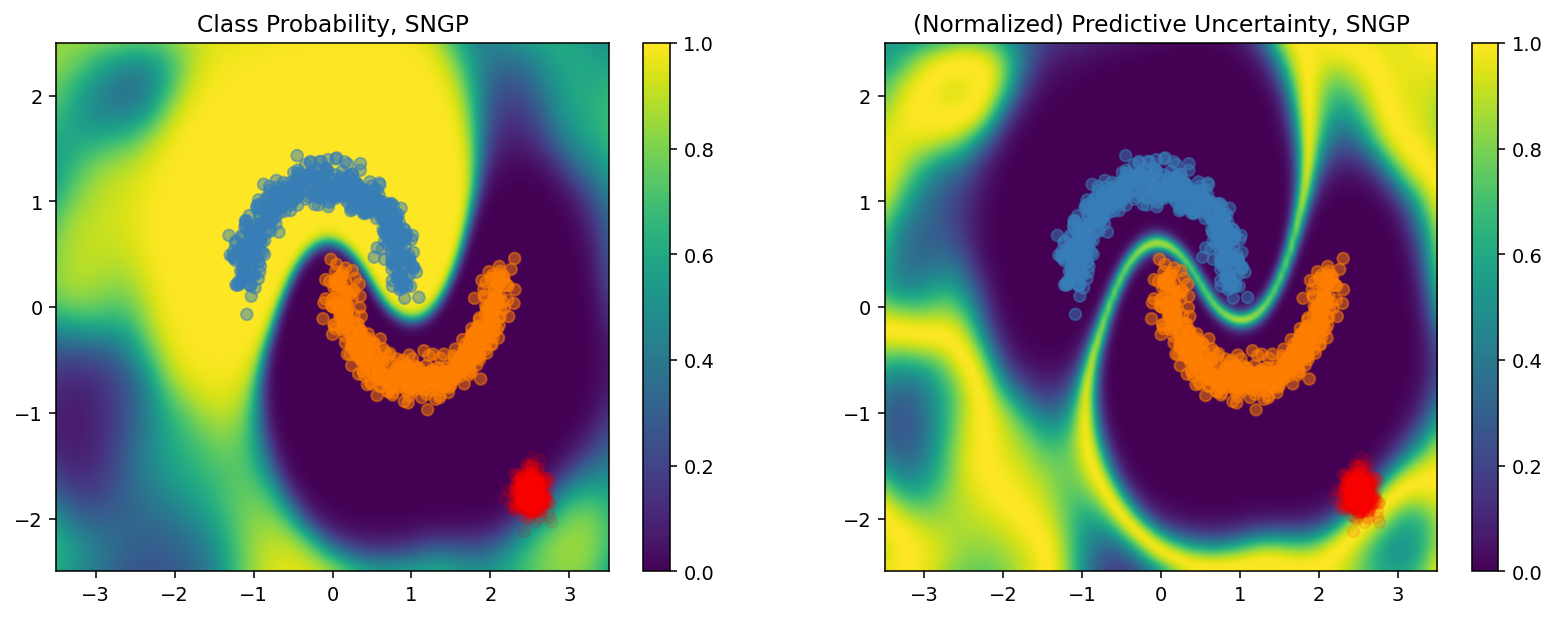

In [140]:
plot_predictions(sngp_probs, model_name="SNGP")


We can see here that SNGP's output is more dependant on the distance from the data manifold. Results here look somewhat less clean than in https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb#scrollTo=raHP5Vuiuku9, which may be to do with my custom implementation of RandomFourierFeature. This is being worked on actively.